<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/Benchmark_(MobileNetV3Large)_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benchmark CNN Model**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook ใช้สำหรับการ Train CNN Model

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com

## **Section 0: Import important library**

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0


In [2]:
import os
import itertools
import time
from psutil import virtual_memory

import pandas as pd
import numpy as np
import random as rd

import tensorflow as tf
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.saliency import Saliency
import tf_keras_vis
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import sklearn
import joblib

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
import albumentations as A

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [4]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [5]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


In [6]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Tue Oct 28 14:50:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Section 1: Preparing the directory for dataset and model**

### **In G-Drive Directory**

In [7]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling.zip"
INDEX_SETTING = f"{DRIVE_DIR}/datasets/indexSetting"

In [8]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

In [9]:
MODEL_PATH = f"{DRIVE_DIR}/models" # <= สำหรับเก็บ Log Model ต่าง ๆ
MODEL_NAME = "MobileNetV3Large" # <= Model อะไร
OPTIMIZER_NAME = "Adam" # <= Optimizer อะไร
TYPE = "Fine Tuned" # <= Fine-Tuned หรือ Feature Extraction
ROUND_NUM = 1 # <= รันครั้งที่เท่าไหร่
MODEL_FULL_PATH = f"{MODEL_PATH}/{MODEL_NAME}_{TYPE}_{OPTIMIZER_NAME}_{ROUND_NUM}"
ASSETS_FOR_MODEL_PATH = f"{MODEL_FULL_PATH}/assets" # <= สำหรับเก็บรูปภาพต่าง ๆ จากโมเดล

os.makedirs(MODEL_FULL_PATH, exist_ok=True)
os.makedirs(ASSETS_FOR_MODEL_PATH, exist_ok=True)

In [10]:
MODEL_KERAS_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.keras"
MODEL_H5_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.h5"
MODEL_TFLITE_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.tflite"
MODEL_CHECKPOINT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_best.keras"
MODEL_TENSORBOARD_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_tensorboard.logs"
MODEL_HISTORY_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_history.csv"
MODEL_JSON_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_json.json"
MODEL_REPORT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_report.csv"

### **In Runtime Directory**

In [11]:
!unzip /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling.zip -d /content/ham10000DatasetOversampling

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0027797_aug_1990.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0028965_aug_3148.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0034134.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0034243_aug_1087.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0033496_aug_2153.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0033216_aug_215.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0032522.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0032408_aug_2136.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0034275_aug_1075.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0030417.jpg  
  inflating: /content/ham10000DatasetOversampling/train/mel/ISIC_0032214_aug_685.jpg  
  in

In [12]:
DATASET_DIR = "/content/ham10000DatasetOversampling"

## **Section 2: Preprocessing and augmentaion images**

### **Load dataset**

In [13]:
class MultiModelDatasetPipeline:
    def __init__(self,
                 transform=None,
                 rescale=None,
                 preprocess_input=None
                 ):
        self.transform = transform
        self.rescale = rescale
        self.preprocess_input = preprocess_input
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.class_names = None

    def _transform_function(self, img_numpy):
        raw_img = {"image": img_numpy}
        transform_img = self.transform(**raw_img)
        return transform_img["image"].astype(np.float32)

    @tf.function
    def _apply_transform(self, img_tensor, img_size):
        transformed = tf.numpy_function(
            func=self._transform_function,
            inp=[img_tensor],
            Tout=tf.float32
        )
        transformed.set_shape([img_size[0], img_size[1], 3])
        return transformed

    def _load_and_resize(self, filepath, metadata, label, img_size):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, metadata, label

    def _finalize_data(self, img, metadata, label,
                       num_classes, img_size, meta_shape=17,
                       is_training=False, class_mode="categorical"):

        if is_training and self.transform:
            img = self._apply_transform(img, img_size)

        if self.preprocess_input:
            img = self.preprocess_input(img)
        elif self.rescale:
            img = img * self.rescale

        label = tf.cast(label, tf.int32)
        if class_mode == "categorical":
            label = tf.one_hot(label, num_classes)  # shape: (num_classes,)
        elif class_mode == "sparse":
            label = label  # keep as integer scalar
        else:
            raise ValueError(f"Unknown class_mode: {class_mode}")

        if metadata is None:
            batch_size = tf.shape(img)[0]
            metadata = tf.zeros((batch_size, meta_shape), dtype=tf.float32)
        else:
            metadata = tf.cast(metadata, tf.float32)

        return ((img, metadata), label)

    def flow_from_dataframe(
            self,
            df,
            X_cols,
            X_meta=None,
            y_cols=None,
            num_classes=None,
            class_name_col=None,
            target_size=(224, 224),
            batch_size=32,
            is_training=False,
            seed=42,
            class_mode="categorical"
            ):

        num_files = len(df)

        if is_training and class_name_col and self.class_names is None:
            try:
                mapping_df = df[[y_cols, class_name_col]].drop_duplicates().sort_values(by=y_cols)
                self.class_names = mapping_df[class_name_col].tolist()
                if len(self.class_names) != num_classes:
                     print(f"Warning: Found {len(self.class_names)} unique names, but num_classes={num_classes}.")
            except Exception as e:
                print(f"Could not build class name list from '{class_name_col}': {e}. Defaulting to numeric names.")
                self.class_names = [str(i) for i in range(num_classes)]
        elif self.class_names is None:
             self.class_names = [str(i) for i in range(num_classes)]

        class_indices = dict(enumerate(self.class_names))
        print(f"Found {num_files} files belonging to {num_classes} classes.")
        print(f"Class indices: {class_indices}")

        if X_meta is None:
            X_meta_data = [None] * len(df)
        else:
            X_meta_data = X_meta

        dataset = tf.data.Dataset.from_tensor_slices(
            (df[X_cols].values, X_meta_data, df[y_cols].values)
        )

        dataset = dataset.map(
            lambda f, m, l: self._load_and_resize(f, m, l, target_size),
            num_parallel_calls=self.AUTOTUNE
        )
        dataset = dataset.cache()

        map_func = lambda img, m, l: self._finalize_data(
            img, m, l, num_classes, target_size,
            meta_shape=17,
            is_training=is_training,
            class_mode=class_mode
        )

        if is_training:
            dataset = dataset.shuffle(buffer_size=len(df), seed=seed, reshuffle_each_iteration=True)

        dataset = (
            dataset
            .map(map_func, num_parallel_calls=self.AUTOTUNE)
            .batch(batch_size)
            .prefetch(buffer_size=self.AUTOTUNE)
        )
        return dataset

In [14]:
df_train = pd.read_csv(f"{INDEX_SETTING}/metadata_train_new.csv")
df_val = pd.read_csv(f"{INDEX_SETTING}/metadata_val_new.csv")
df_test = pd.read_csv(f"{INDEX_SETTING}/metadata_test_new.csv")
metadata_preprocessing = joblib.load(f"{INDEX_SETTING}/metadata_preprocessing_new.joblib")

print("Check shape of dataframe")
print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Check shape of dataframe
Train shape: (15626, 10)
Validation shape: (1979, 10)
Test shape: (1956, 10)


In [15]:
X_meta_train = metadata_preprocessing.transform(df_train)
X_meta_val = metadata_preprocessing.transform(df_val)
X_meta_test = metadata_preprocessing.transform(df_test)
print("Transform complete.")

print("Check shape of metadata")
print(f"X Train metadata shape: {X_meta_train.shape}")
print(f"X Validation metadata shape: {X_meta_val.shape}")
print(f"X Test metadata shape: {X_meta_test.shape}")

Transform complete.
Check shape of metadata
X Train metadata shape: (15626, 17)
X Validation metadata shape: (1979, 17)
X Test metadata shape: (1956, 17)


In [16]:
META_SHAPE = (X_meta_train.shape[1], )
print(f"Metadata shape: {META_SHAPE}")

Metadata shape: (17,)


In [17]:
def select_preprocess_input(model_name):
    if model_name == "ResNet50":
        preprocess_input = keras.applications.resnet50.preprocess_input
    elif model_name == "MobileNetV3Large" or model_name == "MobileNetV3Small":
        preprocess_input = keras.applications.mobilenet_v3.preprocess_input
    elif model_name == "Xception":
        preprocess_input = keras.applications.xception.preprocess_input
    else:
        preprocess_input = None
    return preprocess_input

In [18]:
preprocess_input = select_preprocess_input(MODEL_NAME)
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = IMAGE_SIZE + (3, )
BATCH_SIZE = 64
EPOCHS = 30

In [19]:
class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
idx_to_class = {idx: name for idx, name in enumerate(class_names)}
NUM_CLASSES = len(class_names)
print(f"Index to class: {idx_to_class}")
print(f"Number of classes: {NUM_CLASSES}")

Index to class: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Number of classes: 7


In [20]:
transform = A.Compose([
    A.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.05,
        hue=0.02,
        p=0.3
    )
], seed=SEED)

pipeline = MultiModelDatasetPipeline(
    transform=transform,
    rescale=None,
    preprocess_input=preprocess_input
)

In [21]:
ds_train = pipeline.flow_from_dataframe(
    df=df_train,
    X_cols="filepaths",
    X_meta=X_meta_train,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=True,
    batch_size=BATCH_SIZE,
    seed=SEED
)

ds_val = pipeline.flow_from_dataframe(
    df=df_val,
    X_cols="filepaths",
    X_meta=X_meta_val,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

ds_test = pipeline.flow_from_dataframe(
    df=df_test,
    X_cols="filepaths",
    X_meta=X_meta_test,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

Found 15626 files belonging to 7 classes.
Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Found 1979 files belonging to 7 classes.
Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Found 1956 files belonging to 7 classes.
Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


## **Section 3: Preparing the model**

### **Define callback function**

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=5,
    mode="max",
    min_lr=1e-08,
    verbose=1
) # Reduce learning rate callback

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
) # Model checkpoint for save best model file

tensorboard = keras.callbacks.TensorBoard(
    log_dir=MODEL_TENSORBOARD_PATH,
    histogram_freq=1,
    write_graph=True,
    write_images=True
) # Tensorboard file

callback_list = [reduce_lr, model_checkpoint, tensorboard]

### **Model parameters**

In [ ]:
import tensorflow as tf
from tensorflow import keras

def build_model(input_shape, meta_shape, num_classes, trainable=False):
    image_input = keras.layers.Input(shape=input_shape, name="image_input")
    meta_input = keras.layers.Input(shape=meta_shape, name="metadata_input")

    base_model = keras.applications.MobileNetV3Large(
        input_tensor=image_input,
        include_top=False,
        weights="imagenet"
    )
    for layer in base_model.layers:
        layer.trainable = trainable

    # ===== Image branch =====
    image_features = keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    image_features = keras.layers.BatchNormalization(name="norm_1")(image_features)
    image_features = keras.layers.Dense(256, activation="relu", name="img_fc1")(image_features)
    image_features = keras.layers.Dropout(0.3, name="img_dropout")(image_features)
    image_features = keras.layers.Dense(128, activation="relu", name="img_fc2")(image_features)

    # ===== Metadata branch =====
    meta_features = keras.layers.Dense(64, activation="relu", name="meta_fc1")(meta_input)
    meta_features = keras.layers.BatchNormalization(name="norm_2")(meta_features)
    meta_features = keras.layers.Dense(32, activation="relu", name="meta_fc2")(meta_features)
    meta_features = keras.layers.Dropout(0.2, name="meta_dropout")(meta_features)

    # ===== Metadata Attention =====
    attn_meta = keras.layers.Dense(32, activation="sigmoid", name="meta_attention")(meta_features)
    meta_features = keras.layers.Multiply(name="meta_attention_multi")([meta_features, attn_meta])

    # ===== Combine branches =====
    combined = keras.layers.Concatenate(name="concat_features")([image_features, meta_features])
    combined = keras.layers.BatchNormalization(name="norm_3")(combined)

    # ===== Combined Attention =====
    attn_combined = keras.layers.Dense(
        tf.keras.backend.int_shape(combined)[-1],
        activation="sigmoid",
        name="combined_attention"
    )(combined)
    combined = keras.layers.Multiply(name="combined_attention_multi")([combined, attn_combined])

    # ===== Head =====
    x = keras.layers.Dropout(0.5, name="head_dropout")(combined)
    x = keras.layers.Dense(128, activation="relu", name="head_fc1")(x)
    x = keras.layers.BatchNormalization(name="norm_4")(x)
    x = keras.layers.Dense(64, activation="relu", name="head_fc2")(x)
    predictions = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = keras.models.Model(inputs=[image_input, meta_input], outputs=predictions)
    return model

In [ ]:
model = build_model(
    input_shape=INPUT_SHAPE,
    meta_shape=META_SHAPE,
    num_classes=NUM_CLASSES,
    trainable=True
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer = keras.optimizers.AdamW(
        learning_rate=1e-04,
        weight_decay=1e-05,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name="Adam"
    ),
    loss = keras.losses.CategoricalCrossentropy(name="loss"),
    metrics = [
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,339,879 (12.74 MB)

 Trainable params: 3,312,855 (12.64 MB)

 Non-trainable params: 27,024 (105.56 KB)

## **Section 4: Training the model**

In [ ]:
training_start = time.time()

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
)

training_end = time.time()
training_time = training_end - training_start
print(f"\n Training completed in {training_time:.4f} seconds")

Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2591 - loss: 2.0471 - precision: 0.4110 - recall: 0.0892
Epoch 1: val_accuracy improved from -inf to 0.67863, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_Fine Tuned_Adam_1/MobileNetV3Large_best.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 181s 374ms/step - accuracy: 0.2594 - loss: 2.0462 - precision: 0.4116 - recall: 0.0894 - val_accuracy: 0.6786 - val_loss: 1.1599 - val_precision: 0.8832 - val_recall: 0.3744 - learning_rate: 1.0000e-04
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4524 - loss: 1.4360 - precision: 0.7113 - recall: 0.2166
Epoch 2: val_accuracy improved from 0.67863 to 0.69581, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_Fine Tuned_Adam_1/MobileNetV3Large_best.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 89s 364ms/step - accuracy: 0.4524 - loss: 1.4358 - precision: 0.7113 - recall: 0.2167 - val_accuracy: 0.6958 - val_loss: 0.9385

### **Save the model config**

In [ ]:
# Save model history
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_PATH, index=False)
print(f"History has been saved at {MODEL_HISTORY_PATH}")

History has been saved at /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_Fine Tuned_Adam_1/MobileNetV3Large_history.csv


In [ ]:
# Save model file and tensorboard
model.save(MODEL_KERAS_PATH) # Keras format
print(f"Model keras format has been saved to: {MODEL_KERAS_PATH}")
model.save(MODEL_H5_PATH) # h5 format
print(f"Model h5 format has been saved to: {MODEL_H5_PATH}")
#model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

Model keras format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_Fine Tuned_Adam_1/MobileNetV3Large.keras
Model h5 format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_Fine Tuned_Adam_1/MobileNetV3Large.h5


In [22]:
model = keras.models.load_model(MODEL_KERAS_PATH) # Load best weight model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_TFLITE_PATH, "wb") as f:
    f.write(tflite_model) # tflite format
    print(f"Model tflite format has been saved to: {MODEL_TFLITE_PATH}")

json_model = model.to_json() #Save as json format
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(json_model)
    print(f"Model json format has been saved to: {MODEL_JSON_PATH}")

Saved artifact at '/tmp/tmpytbe14bb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 17), dtype=tf.float32, name='metadata_input')]
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134729638018320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134729638012752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134729638015248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134729638017168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134729638013328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134729638011792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134727830071504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134727830069776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134727830067088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13472783

## **Section 5: Evaluation the model**

In [ ]:
results = model.evaluate(ds_test, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7207 - loss: 1.2982 - precision: 0.7286 - recall: 0.7140


In [ ]:
results

{'accuracy': 0.8251533508300781,
 'loss': 0.8025000691413879,
 'precision': 0.8311755657196045,
 'recall': 0.8205521702766418}

In [ ]:
loss = results['loss']
accuracy = results['accuracy']
precision = results['precision']
recall = results['recall']

print(f"--Final Test Results--")
print(f"Loss      : {loss:.4f}")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")

--Final Test Results--
Loss      : 0.8025
Accuracy  : 0.8252
Precision : 0.8312
Recall    : 0.8206


In [23]:
y_pred_prob = model.predict(ds_test)

y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_onehot = keras.utils.to_categorical(y_pred, num_classes=NUM_CLASSES)

y_true_batches = []
for images, labels in ds_test:
    y_true_batches.append(labels.numpy())

y_true_onehot = np.concatenate(y_true_batches, axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step


In [ ]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_onehot shape: {y_pred_onehot.shape}")
print(f"y_true_onehot shape: {y_true_onehot.shape}")

y_pred shape: (1956,)
y_true shape: (1956,)
y_pred_onehot shape: (1956, 7)
y_true_onehot shape: (1956, 7)


### **Top-1 and Top-5 accuracy**

In [ ]:
# Top-1 Accuracy and Error
top_1 = keras.metrics.TopKCategoricalAccuracy(k=1)
top_1.update_state(y_true_onehot, y_pred_prob)
top_1_acc = top_1.result().numpy()
top_1_err = 1 - top_1_acc
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Error: {top_1_err:.4f}")

# Top-5 Accuracy and Error
top_5 = keras.metrics.TopKCategoricalAccuracy(k=5)
top_5.update_state(y_true_onehot, y_pred_prob)
top_5_acc = top_5.result().numpy()
top_5_err = 1 - top_5_acc
print(f"Top-5 Accuracy: {top_5_acc:.4f}")
print(f"Top-5 Error: {top_5_err:.4f}")

Top-1 Accuracy: 0.8252
Top-1 Error: 0.1748
Top-5 Accuracy: 0.9969
Top-5 Error: 0.0031


### **Classification Report**

In [ ]:
report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(MODEL_REPORT_PATH, index=True)
report_df

,precision,recall,f1-score,support
akiec,0.582090,0.629032,0.604651,62.000000
bcc,0.771084,0.659794,0.711111,97.000000
bkl,0.781609,0.615385,0.688608,221.000000
df,0.750000,0.310345,0.439024,29.000000
mel,0.570755,0.550000,0.560185,220.000000
nv,0.885424,0.939954,0.911875,1299.000000
vasc,0.827586,0.857143,0.842105,28.000000
accuracy,0.825153,0.825153,0.825153,0.825153
macro avg,0.738364,0.651665,0.679651,1956.000000
weighted avg,0.820181,0.825153,0.819389,1956.000000


### **Training and Validation curve**

In [ ]:
def plot_history(history, save_path=None, fontsize=16, title=None):
    """
        สำหรับ Plot training and validation curve สำหรับ accuracy และ loss
        Args:
            history: ประวัติการ Train ที่ได้จาก model.fit()
            save_path: เซฟภาพเก็บไว้ที่ไหน (optional)
            fontsize: ขนาด font default 16
            title: สำหรับชื่อรูปภาพ (optional)
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["accuracy"]) + 1)

    fig = plt.figure(figsize=(12, 5))

    # --Loss--
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], "b-", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "r-", label="Validation loss")
    plt.title("Training and validation loss", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Loss", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    # --Accuracy--
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], "b-", label="Training accuracy")
    plt.plot(epochs, history_dict["val_accuracy"], "r-", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    plt.tight_layout()

    if title:
        fig.text(0.5, 0.01, f"{title}", ha='center', fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/train_valid_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/train_valid_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

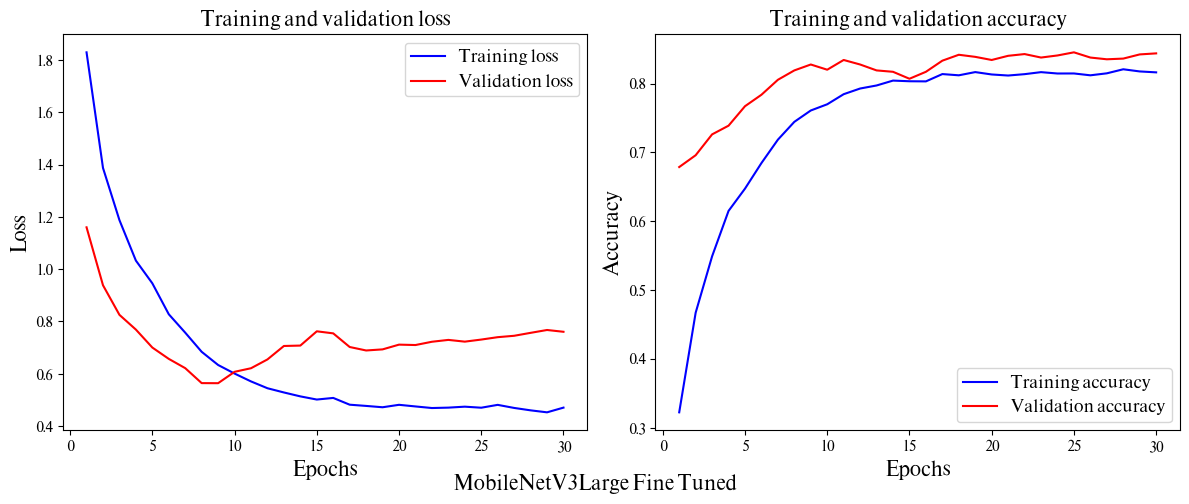

In [ ]:
plot_history(history, save_path=ASSETS_FOR_MODEL_PATH, fontsize=14, title=f"{MODEL_NAME} {TYPE}")

### **Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues,
                          save_path=None, fontsize=12):

    """
        สำหรับ Plot counfusion matrix
        Args:
            cm (array): ค่า confusion matrix ที่ต้องการ plot
            classes (list): รายชื่อคลาส (label names) สำหรับแกน X และ Y
            normalize (bool, default=False): ถ้า True จะทำ normalization ให้ค่าทุกแถวรวมเป็น 1
            title (str, optional): ชื่อกราฟที่จะแสดงด้านบน
            cmap (matplotlib colormap, default=plt.cm.Blues): โทนสีของ heatmap
            save_path (str, optional): โฟลเดอร์ที่จะบันทึกภาพ (ถ้าไม่กำหนดจะไม่บันทึก)
            fontsize (int, default=12): ขนาดตัวอักษรในกราฟ
    """
    correct_predictions = np.trace(cm)
    total_samples = np.sum(cm)
    accuracy = correct_predictions / total_samples
    misclassification_rate = 1 - accuracy

    if title:
        if normalize:
            pic_title = f"{title}\nConfusion Matrix (normalized)"
        else:
            pic_title = f"{title}\nConfusion Matrix"
    else:
        if normalize:
            pic_title = "Confusion Matrix (normalized)"
        else:
            pic_title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(pic_title, fontsize=fontsize, ha="center")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=fontsize,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    metrics_text = (
        f"\nAccuracy: {accuracy:.4f}  |  Misclass: {misclassification_rate:.4f}"
    )
    plt.xlabel(f"Predicted label{metrics_text}", fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        if normalize:
            plt.savefig(f"{save_path}/confusion_matrix_normalized.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix_normalized.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/confusion_matrix.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix.svg", format="svg", bbox_inches="tight")

    plt.show()

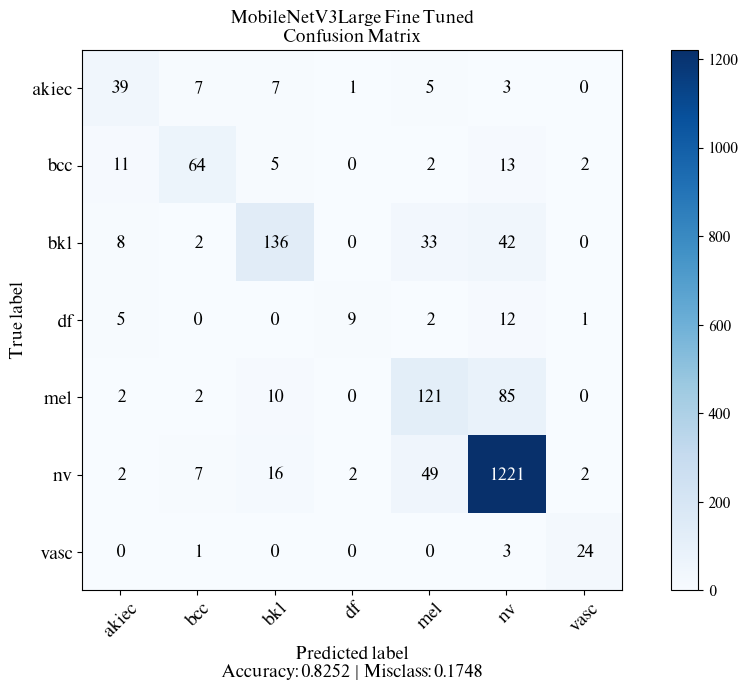

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=False, save_path=ASSETS_FOR_MODEL_PATH)

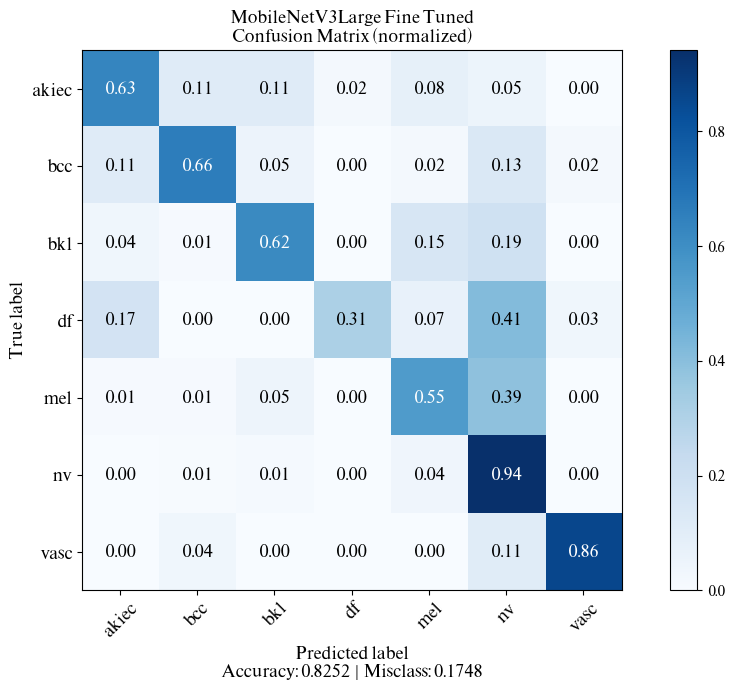

In [ ]:
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=True, save_path=ASSETS_FOR_MODEL_PATH)

### **Plot AUC-ROC Curve**

In [ ]:
def plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, title=None, save_path=None, fontsize=14):
    """
        y_true_onehot (ndarray): ค่า ground truth ในรูปแบบ one-hot encoded (ขนาด n_samples × n_classes)
        y_pred_prob (ndarray): ค่าความน่าจะเป็นที่โมเดลทำนาย (ขนาดเดียวกันกับ y_true_onehot)
        class_names (list): รายชื่อคลาสแต่ละคลาสที่ใช้แสดงในกราฟ
        title (str, optional): ชื่อกราฟ (ถ้าไม่ระบุจะใช้ชื่อเริ่มต้น “Receiver Operating Characteristic (ROC) - Multiclass”)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ (.png และ .svg)
        fontsize (int, default=14): ขนาดตัวอักษรในกราฟ
    """
    n_classes = y_pred_prob.shape[1]
    plt.figure(figsize=(12, 7))

    if title:
        pic_title = f"{title}\nReceiver Operating Characteristic (ROC) - Multiclass"
    else:
        pic_title = "Receiver Operating Characteristic (ROC) - Multiclass"

    for i in range(n_classes):
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color="deeppink", linestyle="--", lw=2,
             label=f"Micro-average (AUC = {roc_auc_micro:.4f})")

    roc_auc_macro = sklearn.metrics.roc_auc_score(y_true_onehot, y_pred_prob, average='macro')
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--",
             label=f"Macro-average (AUC = {roc_auc_macro:.4f})")

    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle=":")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(pic_title, fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=fontsize)
    plt.grid(alpha=0.3)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/roc_auc_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/roc_auc_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

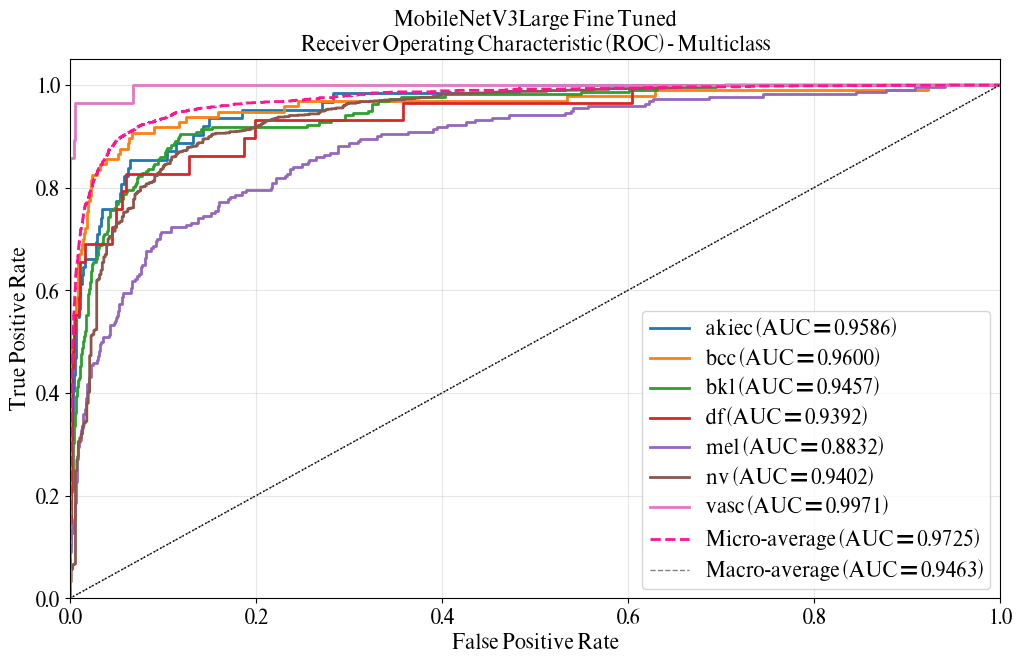

In [ ]:
plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, f"{MODEL_NAME} {TYPE}", ASSETS_FOR_MODEL_PATH)